In [1]:
import os
import sys
from dask.distributed import Client
# client = Client(scheduler_file='/proj/kimyy/Dropbox/source/python/all/mpi/scheduler.json', threads_per_worker=2, n_workers=6)
client = Client(scheduler_file='/proj/kimyy/Dropbox/source/python/all/mpi/scheduler.json')  
# client = Client(scheduler_file='/proj/kimyy/Dropbox/source/python/all/mpi/scheduler_10.json')  

# add private module path for workers
# client.run(lambda: os.environ.update({'PYTHONPATH': '/proj/kimyy/Dropbox/source/python/all/Modules/CESM2'}))
# def add_path():
#     if '/proj/kimyy/Dropbox/source/python/all/Modules/CESM2' not in sys.path:
#         sys.path.append('/proj/kimyy/Dropbox/source/python/all/Modules/CESM2')

# client.run(add_path)

def setup_module_path():
    module_path = '/proj/kimyy/Dropbox/source/python/all/Modules/CESM2'
    if module_path not in sys.path:
        sys.path.append(module_path)

client.run(setup_module_path)

client

<Client: 'tcp://203.247.189.224:34221' processes=4 threads=72, memory=335.28 GiB>

# Load modules

In [2]:
# load public modules

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats
import cmocean
from cmcrameri import cm
import warnings
warnings.simplefilter(action='ignore')
import pandas as pd
import cftime
import pop_tools
from pprint import pprint
import time
import subprocess
import re as re_mod
import cftime
import datetime
from scipy.stats import ttest_1samp
import xcesm

In [3]:
# load private modules

import sys
sys.path.append('/proj/kimyy/Dropbox/source/python/all/Modules/CESM2')
from KYY_CESM2_preprocessing import CESM2_config
# import KYY_CESM2_preprocessing
# import importlib
# importlib.reload(KYY_CESM2_preprocessing)

# Variable configuration

In [4]:
ds_grid = pop_tools.get_grid('POP_gx1v7')

cfg_var_TEMP=CESM2_config()
cfg_var_TEMP.year_s=1850
cfg_var_TEMP.year_e=2024
cfg_var_TEMP.setvar('TEMP')

In [5]:
cut_grid_info = {
    "lonw": 210,
    "lone": 270,
    "lats": -20,
    "latn": 10
}

# Read files

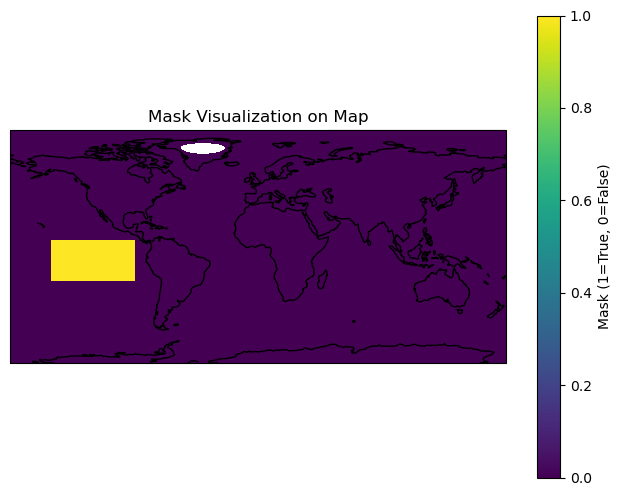

In [6]:
ds=ds_grid
mask = ((ds.TLONG >= cut_grid_info["lonw"]) 
        & (ds.TLONG <= cut_grid_info["lone"]) 
        & (ds.TLAT >= cut_grid_info["lats"]) 
        & (ds.TLAT <= cut_grid_info["latn"]))
iy, ix = np.where(mask)

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(8, 6))

# mask를 1/0으로 변환한 뒤 지도 위에 겹쳐서 표시
pc = ax.pcolormesh(ds.TLONG, ds.TLAT, mask.astype(int),
                   transform=ccrs.PlateCarree(),
                   cmap='viridis')

ax.coastlines()
plt.colorbar(pc, ax=ax, label='Mask (1=True, 0=False)')
plt.title('Mask Visualization on Map')
plt.show()

In [7]:
# define preprocessing function

ds_grid_sub = ds_grid.where(mask, drop=True)
area = ds_grid_sub['TAREA']
weighted_avg_manual = xr.Dataset()

# data = cfg_var_NO3.LE_ds['NO3']
# weighted_sum = (data * area).sum(dim=['nlat','nlon'], skipna=True)
# effective_area = area.where(data.notnull()).sum(dim=['nlat','nlon'], skipna=True)
# weighted_avg_manual['NO3'] = weighted_sum / effective_area



exceptcv=['time','lon','lat','lev', 'TLONG', 'TLAT', 'z_w', cfg_var_TEMP.var]

def process_coords(varname, mask, ds_grid_sub, ds, sd, ed, drop=True, except_coord_vars=exceptcv):
    """Preprocessor function to drop all non-dim coords, which slows down concatenation."""
    coord_vars = []
    for v in np.array(ds.coords) :
        if not v in except_coord_vars:
            coord_vars += [v]
    for v in np.array(ds.data_vars) :
        if not v in except_coord_vars:
            coord_vars += [v]

    # ds = ds.where(mask, drop=True)
    ds= ds.isel(z_t=slice(0, 1))
    ds= ds.isel(z_w=slice(0, 1))
   
    # volume= ds_grid_sub['dz'] * ds_grid_sub['TAREA']
    # weighted_sum = (ds[varname] * volume).sum(dim=['nlat','nlon','z_t'], skipna=True)
    # effective_volume = volume.where(ds[varname].notnull()).sum(dim=['nlat','nlon','z_t'], skipna=True)
    # ds[varname] = weighted_sum / effective_volume
    
    
    if drop:
        ds= ds.drop(coord_vars)
        ds= ds.sel(time=slice(sd, ed))
        return ds
    else:
        return ds.set_coords(coord_vars)


def process_coords_obs(ds, drop=True, except_coord_vars=['time','valid_time', 'lon','lat', 'TLONG', 'TLAT', 'sst', 'PP', 'sla', 'SOMXL030', 'NAV_LON', 'NAV_LAT', 'u10', 'v10']):
    """Preprocessor function to drop all non-dim coords, which slows down concatenation."""
    coord_vars = []
    for v in np.array(ds.coords) :
        if not v in except_coord_vars:
            coord_vars += [v]
    for v in np.array(ds.data_vars) :
        if not v in except_coord_vars:
            coord_vars += [v]

    # ds = ds.where(mask, drop=True)
    # volume= ds_grid_sub['dz'] * ds_grid_sub['TAREA']
    # weighted_sum = (ds[varname] * volume).sum(dim=['nlat','nlon','z_t'], skipna=True)
    # effective_volume = volume.where(ds[varname].notnull()).sum(dim=['nlat','nlon','z_t'], skipna=True)
    # ds[varname] = weighted_sum / effective_volume
    if 'valid_time' in ds:
        ds = ds.rename({'valid_time': 'time'})
    
    if drop:
        ds= ds.drop(coord_vars)
        return ds
    else:
        return ds.set_coords(coord_vars)

start_date = cftime.DatetimeNoLeap(cfg_var_TEMP.year_s, 2, 1)
end_date = cftime.DatetimeNoLeap(cfg_var_TEMP.year_e+1, 1, 1)

In [8]:
start_time = time.time()

filename = (
    "/mnt/lustre/proj/kimyy/Model/CESM2/ESP/for_LIM/LIM_input_LE_" 
    + "x1_" + str(cut_grid_info["lonw"])
    + "_x2_" + str(cut_grid_info["lone"])
    + "_y1_" + str(cut_grid_info["lats"])
    + "_y2_" + str(cut_grid_info["latn"])
    + ".nc"
)

LE_data = xr.open_dataset(filename)

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for writing netcdf: ' + str(elapsed_time))

elasped time for writing netcdf: 0.05643510818481445


In [9]:
# Read Observation dataset (TEMP)
start_time = time.time()

# TEMP
cfg_var_TEMP.OBS_path_load(cfg_var_TEMP.var)
dname=cfg_var_TEMP.OBS_var
cfg_var_TEMP.OBS_ds = xr.open_mfdataset(
    cfg_var_TEMP.OBS_file_list[0][0],
    chunks={'time': 12},
    parallel=True,
    preprocess=lambda ds: process_coords_obs(ds),
    combine="by_coords",
    decode_times=True,  # skip calendar/time decoding
)

cfg_var_TEMP.OBS_ds = cfg_var_TEMP.OBS_ds.rename({cfg_var_TEMP.OBS_var: cfg_var_TEMP.var})
cfg_var_TEMP.OBS_ds.time

# global mean removal for SSH
if cfg_var_TEMP.var=='SSH':
    lat_mask = (ds_grid.TLAT >= -60) & (ds_grid.TLAT <= 60)

    area_selected = ds_grid.TAREA.where(lat_mask, drop=True)  # 선택된 지역의 면적
    ssh_selected = cfg_var_TEMP.OBS_ds[cfg_var_TEMP.var].where(lat_mask, drop=True)  # 선택된 지역의 SSH 데이터

    cfg_var_TEMP.OBS_ds['gm'] = (ssh_selected * area_selected).sum(dim=['nlat', 'nlon']) / area_selected.sum(dim=['nlat', 'nlon'])
    cfg_var_TEMP.OBS_ds['SSH'] = cfg_var_TEMP.OBS_ds[cfg_var_TEMP.var] - cfg_var_TEMP.OBS_ds['gm']


cfg_var_TEMP.OBS_ds = cfg_var_TEMP.OBS_ds.where(mask, drop=True)
area = ds_grid_sub['TAREA']
weighted_sum = (cfg_var_TEMP.OBS_ds['TEMP'] * area).sum(dim=['nlat','nlon'], skipna=True)
effective_area = area.where(cfg_var_TEMP.OBS_ds['TEMP'].notnull()).sum(dim=['nlat','nlon'], skipna=True)
cfg_var_TEMP.OBS_ds['TEMP'] = weighted_sum / effective_area

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading OBS: ' + str(elapsed_time))

elasped time for reading OBS: 162.07309293746948


In [10]:
# data_read

SST_filename = (
    "/mnt/lustre/proj/kimyy/Model/CESM2/ESP/for_LIM/LIM_input_obs_TEMP_" 
    + "x1_" + str(cut_grid_info["lonw"])
    + "_x2_" + str(cut_grid_info["lone"])
    + "_y1_" + str(cut_grid_info["lats"])
    + "_y2_" + str(cut_grid_info["latn"])
    + ".nc"
)

data_SST = xr.open_dataset(SST_filename)

    
SSH_filename = (
    "/mnt/lustre/proj/kimyy/Model/CESM2/ESP/for_LIM/LIM_input_obs_SSH_" 
    + "x1_" + str(cut_grid_info["lonw"])
    + "_x2_" + str(cut_grid_info["lone"])
    + "_y1_" + str(cut_grid_info["lats"])
    + "_y2_" + str(cut_grid_info["latn"])
    + ".nc"
)

data_SSH = xr.open_dataset(SSH_filename)

NPP_filename = (
    "/mnt/lustre/proj/kimyy/Model/CESM2/ESP/for_LIM/LIM_input_obs_photoC_TOT_zint_100m_" 
    + "x1_" + str(cut_grid_info["lonw"])
    + "_x2_" + str(cut_grid_info["lone"])
    + "_y1_" + str(cut_grid_info["lats"])
    + "_y2_" + str(cut_grid_info["latn"])
    + ".nc"
)

data_NPP = xr.open_dataset(NPP_filename)

HBLT_filename = (
    "/mnt/lustre/proj/kimyy/Model/CESM2/ESP/for_LIM/LIM_input_obs_HBLT_" 
    + "x1_" + str(cut_grid_info["lonw"])
    + "_x2_" + str(cut_grid_info["lone"])
    + "_y1_" + str(cut_grid_info["lats"])
    + "_y2_" + str(cut_grid_info["latn"])
    + ".nc"
)

data_HBLT = xr.open_dataset(HBLT_filename)
data_HBLT = data_HBLT.rename({'time_counter': 'time'})

U010_filename = (
    "/mnt/lustre/proj/kimyy/Model/CESM2/ESP/for_LIM/LIM_input_obs_U010_" 
    + "x1_" + str(cut_grid_info["lonw"])
    + "_x2_" + str(cut_grid_info["lone"])
    + "_y1_" + str(cut_grid_info["lats"])
    + "_y2_" + str(cut_grid_info["latn"])
    + ".nc"
)

data_U010 = xr.open_dataset(U010_filename)

V010_filename = (
    "/mnt/lustre/proj/kimyy/Model/CESM2/ESP/for_LIM/LIM_input_obs_V010_" 
    + "x1_" + str(cut_grid_info["lonw"])
    + "_x2_" + str(cut_grid_info["lone"])
    + "_y1_" + str(cut_grid_info["lats"])
    + "_y2_" + str(cut_grid_info["latn"])
    + ".nc"
)

data_V010 = xr.open_dataset(V010_filename)




In [11]:
LE_filename = (
    "/mnt/lustre/proj/kimyy/Model/CESM2/ESP/for_LIM/LIM_input_LE_" 
    + "x1_" + str(cut_grid_info["lonw"])
    + "_x2_" + str(cut_grid_info["lone"])
    + "_y1_" + str(cut_grid_info["lats"])
    + "_y2_" + str(cut_grid_info["latn"])
    + ".nc"
)
data_LE = xr.open_dataset(LE_filename)

In [12]:
# Read Observation dataset (TEMP)
start_time = time.time()

# TEMP
cfg_var_TEMP.OBS_path_load(cfg_var_TEMP.var)
dname=cfg_var_TEMP.OBS_var
cfg_var_TEMP.OBS_ds = xr.open_mfdataset(
    cfg_var_TEMP.OBS_file_list[0][0],
    chunks={'time': 12},
    parallel=True,
    preprocess=lambda ds: process_coords_obs(ds),
    combine="by_coords",
    decode_times=True,  # skip calendar/time decoding
)

cfg_var_TEMP.OBS_ds = cfg_var_TEMP.OBS_ds.rename({cfg_var_TEMP.OBS_var: cfg_var_TEMP.var})

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading OBS: ' + str(elapsed_time))

elasped time for reading OBS: 158.16179823875427


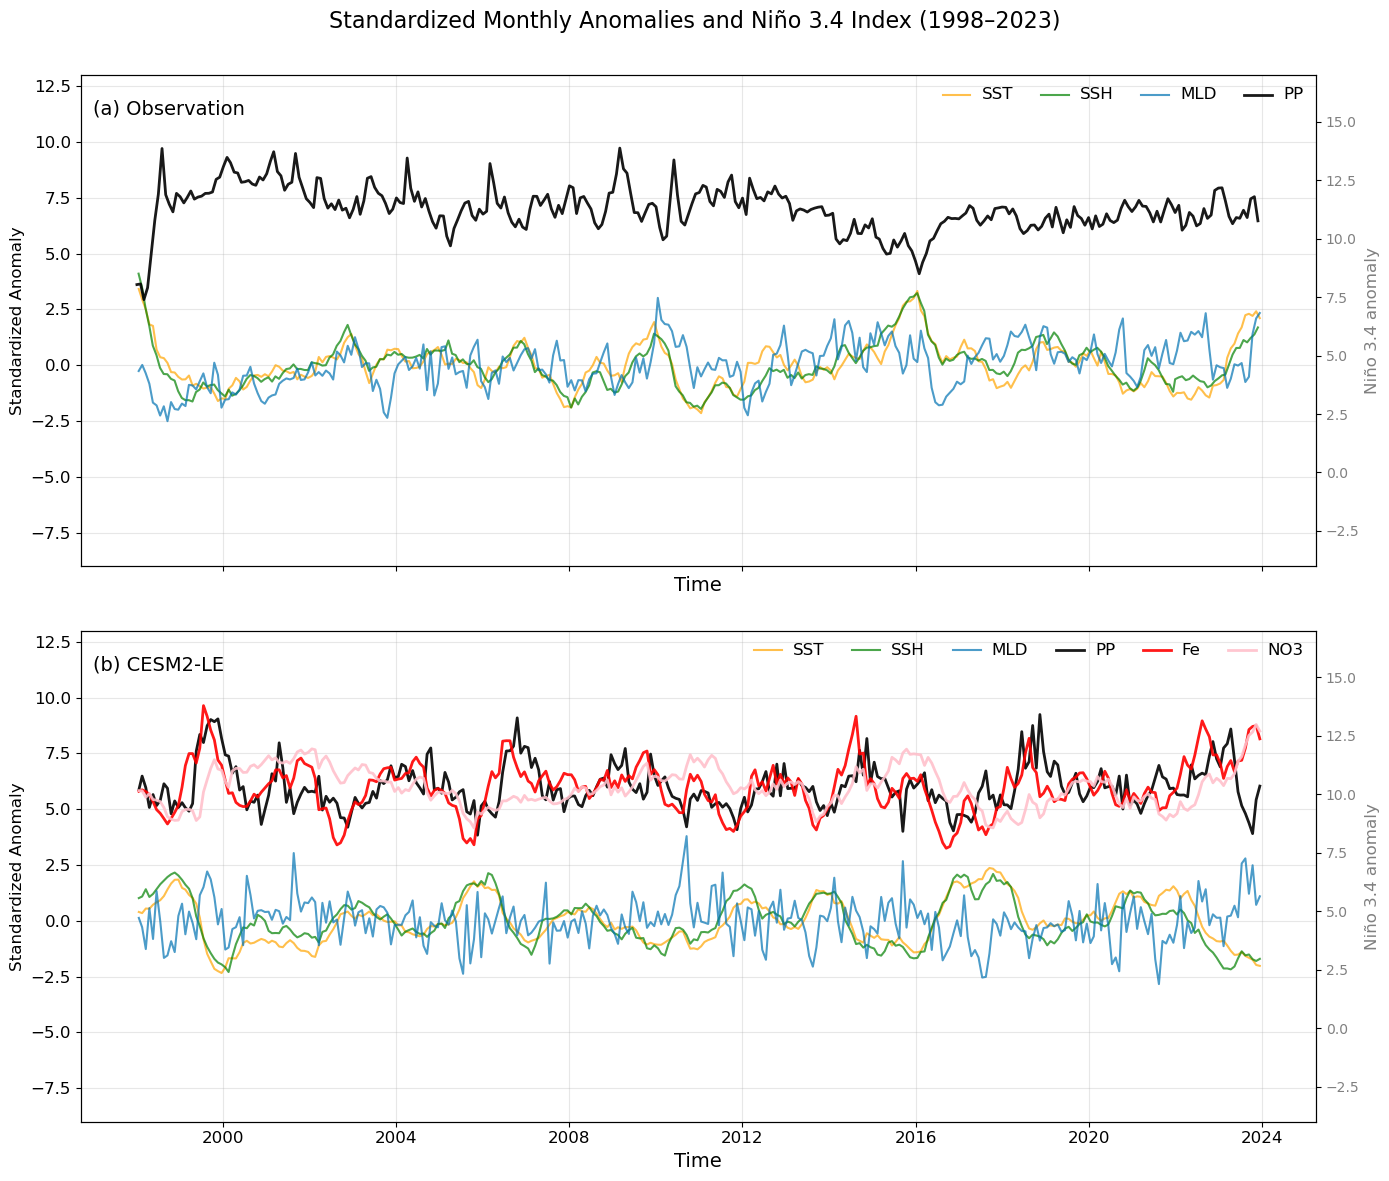

In [16]:
def ensure_datetimeindex(da):
    """Convert any CFTimeIndex or nonstandard time coordinate to pandas.DatetimeIndex."""
    import pandas as pd
    if 'time' in da.coords:
        # Try standard conversion first
        try:
            da['time'] = da.indexes['time'].to_datetimeindex()
        except Exception:
            # fallback: approximate calendar conversion
            da['time'] = pd.to_datetime(da['time'].values)
    return da

import matplotlib.pyplot as plt
import numpy as np

# -------------------- Figure Layout -------------------- #
fig, axes = plt.subplots(
    nrows=2, ncols=1, figsize=(14, 12),
    sharex=True, gridspec_kw={'height_ratios': [1, 1]}
)
ax_obs, ax_le = axes

# =======================================================
# (a) OBSERVATION PANEL
# =======================================================

data_subset = data_SST.sel(time=slice("1998-01-01", "2023-12-31"))
SST_mon_clim = data_subset.groupby("time.month").mean(dim="time")
SST_anom = data_subset.groupby("time.month") - SST_mon_clim
SST_anom = SST_anom / SST_anom.std()

data_subset = data_SSH.sel(time=slice("1998-01-01", "2023-12-31"))
SSH_mon_clim = data_subset.groupby("time.month").mean(dim="time")
SSH_anom = data_subset.groupby("time.month") - SSH_mon_clim
SSH_anom = SSH_anom / SSH_anom.std()

data_subset = data_NPP.sel(time=slice("1998-01-01", "2023-12-31"))
NPP_mon_clim = data_subset.groupby("time.month").mean(dim="time")
NPP_anom = data_subset.groupby("time.month") - NPP_mon_clim
NPP_anom = NPP_anom / NPP_anom.std()

data_subset = data_HBLT.sel(time=slice("1998-01-01", "2023-12-31"))
HBLT_mon_clim = data_subset.groupby("time.month").mean(dim="time")
HBLT_anom = data_subset.groupby("time.month") - HBLT_mon_clim
HBLT_anom = HBLT_anom / HBLT_anom.std()

SST_anom['obs_SST'].plot(ax=ax_obs, label='SST', color='orange', alpha=0.7)
SSH_anom['obs_SSH'].plot(ax=ax_obs, label='SSH', color='green', alpha=0.7)
HBLT_anom['obs_HBLT'].plot(ax=ax_obs, label='MLD', color='#0072B2', alpha=0.7)

# Biogeochemical (offset)
offset_obs = 7.0
NPP_anom_shifted_obs = NPP_anom['obs_photoC_TOT_zint_100m'] + offset_obs
NPP_anom_shifted_obs.plot(ax=ax_obs, label='PP', color='black', linewidth=2.0, alpha=0.9)

# Niño bar
ax2_obs = ax_obs.twinx()

# Axis settings
ax_obs.set_ylim(-9, 13)
ax2_obs.set_ylim(-4, 17)
ax2_obs.tick_params(axis='y', labelcolor='gray', labelsize=10)
ax2_obs.set_ylabel("Niño 3.4 anomaly", fontsize=12, color='gray')
ax_obs.grid(alpha=0.3)
ax_obs.set_ylabel("Standardized Anomaly", fontsize=12)
ax_obs.text(0.01, 0.95, "(a) Observation", transform=ax_obs.transAxes,
            fontsize=14, va='top')
ax_obs.legend(loc='upper right', frameon=False, ncol=4)



# =======================================================
# (b) CESM2-LE PANEL
# =======================================================
data_subset = data_LE.TEMP.sel(time=slice("1998-01-01", "2023-12-31"))
SST_mon_clim = data_subset.groupby("time.month").mean(dim="time")
SST_anom = data_subset.groupby("time.month") - SST_mon_clim
SST_anom = SST_anom / SST_anom.std()
SST_anom_allmem= SST_anom
SST_anom= SST_anom.isel(ens_LE=0)

data_subset = data_LE.SSH.sel(time=slice("1998-01-01", "2023-12-31"))
SSH_mon_clim = data_subset.groupby("time.month").mean(dim="time")
SSH_anom = data_subset.groupby("time.month") - SSH_mon_clim
SSH_anom = SSH_anom / SSH_anom.std()
SSH_anom_allmem=SSH_anom
SSH_anom= SSH_anom.isel(ens_LE=0)

data_subset = data_LE.photoC_TOT_zint_100m.sel(time=slice("1998-01-01", "2023-12-31"))
NPP_mon_clim = data_subset.groupby("time.month").mean(dim="time").isel(ens_LE=0)
NPP_anom = data_subset.groupby("time.month") - NPP_mon_clim
NPP_anom = NPP_anom / NPP_anom.std()
NPP_anom_allmem=NPP_anom
NPP_anom= NPP_anom.isel(ens_LE=0)

data_subset = data_LE.HBLT.sel(time=slice("1998-01-01", "2023-12-31"))
HBLT_mon_clim = data_subset.groupby("time.month").mean(dim="time")
HBLT_anom = data_subset.groupby("time.month") - HBLT_mon_clim
HBLT_anom = HBLT_anom / HBLT_anom.std()
HBLT_anom_allmem=HBLT_anom
HBLT_anom= HBLT_anom.isel(ens_LE=0)

data_subset = data_LE.Fe.sel(time=slice("1998-01-01", "2023-12-31"))
Fe_mon_clim = data_subset.groupby("time.month").mean(dim="time")
Fe_anom = data_subset.groupby("time.month") - Fe_mon_clim
Fe_anom = Fe_anom / Fe_anom.std()
Fe_anom_allmem=Fe_anom
Fe_anom= Fe_anom.isel(ens_LE=0)

data_subset = data_LE.NO3.sel(time=slice("1998-01-01", "2023-12-31"))
NO3_mon_clim = data_subset.groupby("time.month").mean(dim="time")
NO3_anom = data_subset.groupby("time.month") - NO3_mon_clim
NO3_anom = NO3_anom / NO3_anom.std()
NO3_anom_allmem=NO3_anom
NO3_anom= NO3_anom.isel(ens_LE=0)



for da in [SST_anom, SSH_anom, HBLT_anom, NPP_anom,
           Fe_anom, NO3_anom]:
    ensure_datetimeindex(da)


SST_anom.plot(ax=ax_le, label='SST', color='orange', alpha=0.7)
SSH_anom.plot(ax=ax_le, label='SSH', color='green', alpha=0.7)
HBLT_anom.plot(ax=ax_le, label='MLD', color='#0072B2', alpha=0.7)

offset_le = 6.0
NPP_anom_shifted_le = NPP_anom + offset_le
Fe_anom_shifted_le = Fe_anom + offset_le
NO3_anom_shifted_le = NO3_anom + offset_le

NPP_anom_shifted_le.plot(ax=ax_le, label='PP', color='black', linewidth=2.0, alpha=0.9)
Fe_anom_shifted_le.plot(ax=ax_le, label='Fe', color='red', linewidth=2.0, alpha=0.9)
NO3_anom_shifted_le.plot(ax=ax_le, label='NO3', color='pink', linewidth=2.0, alpha=0.9)

# Niño bar
ax2_le = ax_le.twinx()

# Axis settings
ax_le.set_ylim(-9, 13)
ax2_le.set_ylim(-4, 17)
ax2_le.tick_params(axis='y', labelcolor='gray', labelsize=10)
ax2_le.set_ylabel("Niño 3.4 anomaly", fontsize=12, color='gray')
ax_le.grid(alpha=0.3)
ax_le.set_ylabel("Standardized Anomaly", fontsize=12)
ax_le.text(0.01, 0.95, "(b) CESM2-LE", transform=ax_le.transAxes,
           fontsize=14, va='top')
ax_le.set_title(' ')
ax2_le.set_title(' ')

# =======================================================
# Common X and Layout
# =======================================================
ax_obs.set_xlabel("Time", fontsize=14)
ax_le.set_xlabel("Time", fontsize=14)
for ax in [ax_obs, ax_le]:
    ax.tick_params(labelsize=12)
    leg = ax.legend(loc='upper right', frameon=False, ncol=6)
    plt.setp(leg.get_texts(), fontsize=12)


fig.suptitle("Standardized Monthly Anomalies and Niño 3.4 Index (1998–2023)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


In [17]:
import xarray as xr
import pandas as pd

# Variables to analyze (xarray.DataArray with dims like ['ens_LE','time'])
var_dict = {
    "SST":  SST_anom_allmem,
    "SSH":  SSH_anom_allmem,
    "HBLT": HBLT_anom_allmem,
    "Fe":   Fe_anom_allmem,
    "NO3":  NO3_anom_allmem,
    "Nino3.4": nino_anom_allmem,
}

results = {}       # summary stats (mean/std/min/max) per variable
corr_dict = {}     # full per-ensemble correlation arrays per variable

for name, da in var_dict.items():
    # 1) ensemble-wise correlation along time
    corr = xr.corr(NPP_anom_allmem, da, dim="time")  # -> dims: ['ens_LE'] (and others if present)
    corr_dict[name] = corr  # store full correlation array for later inspection

    # 2) summary stats across ensemble dimension
    mean_val = float(corr.mean("ens_LE").values)
    std_val  = float(corr.std("ens_LE").values)
    min_val  = float(corr.min("ens_LE").values)
    max_val  = float(corr.max("ens_LE").values)

    results[name] = {"mean": mean_val, "std": std_val, "min": min_val, "max": max_val}

# Make a DataFrame of summary stats
df_corr = pd.DataFrame(results).T
df_corr = df_corr[["mean","std","min","max"]]  # column order

print(df_corr)

# (Optional) Save summaries to CSV
# df_corr.to_csv("corr_summary_by_variable.csv", index=True)

# (Optional) Save full per-ensemble correlations to a single NetCDF
# ds_corr = xr.Dataset({name: arr for name, arr in corr_dict.items()})
# ds_corr.to_netcdf("corr_per_ensemble.nc")

NameError: name 'nino_anom_allmem' is not defined

In [ ]:

print("NPP vs HBLT correlation:", corr_dict['HBLT'].sel(ens_LE=0).values)
print("NPP vs SST correlation:", corr_dict['SST'].sel(ens_LE=0).values)
print("NPP vs SSH correlation:", corr_dict['SSH'].sel(ens_LE=0).values)
print("NPP vs Fe correlation:", corr_dict['Fe'].sel(ens_LE=0).values)
print("NPP vs NO3 correlation:", corr_dict['NO3'].sel(ens_LE=0).values)
print("NPP vs nino correlation:", corr_dict['Nino3.4'].sel(ens_LE=0).values)

In [ ]:
LE_corr_HBLT=xr.corr(NPP_anom, HBLT_anom) 
LE_corr_SST=xr.corr(NPP_anom, SST_anom) 
LE_corr_SSH=xr.corr(NPP_anom, SSH_anom) 
LE_corr_Fe=xr.corr(NPP_anom, Fe_anom) 
LE_corr_NO3=xr.corr(NPP_anom, NO3_anom) 
LE_corr_nino=xr.corr(NPP_anom, nino_anom) 

print("NPP vs HBLT correlation:", LE_corr_HBLT.values)
print("NPP vs SST correlation:", LE_corr_SST.values)
print("NPP vs SSH correlation:", LE_corr_SSH.values)
print("NPP vs Fe correlation:", LE_corr_Fe.values)
print("NPP vs NO3 correlation:", LE_corr_NO3.values)
print("NPP vs nino correlation:", LE_corr_nino.values)

In [20]:
data_LE

<xarray.Dataset> Size: 7MB
Dimensions:               (ens_LE: 50, time: 2100)
Coordinates:
  * ens_LE                (ens_LE) int64 400B 0 1 2 3 4 5 ... 44 45 46 47 48 49
  * time                  (time) object 17kB 1850-01-17 00:00:00 ... 2024-12-...
Data variables:
    TEMP                  (ens_LE, time) float64 840kB ...
    photoC_TOT_zint_100m  (ens_LE, time) float64 840kB ...
    SSH                   (ens_LE, time) float64 840kB ...
    TAUX                  (ens_LE, time) float64 840kB ...
    TAUY                  (ens_LE, time) float64 840kB ...
    NO3                   (ens_LE, time) float64 840kB ...
    Fe                    (ens_LE, time) float64 840kB ...
    HBLT                  (ens_LE, time) float64 840kB ...

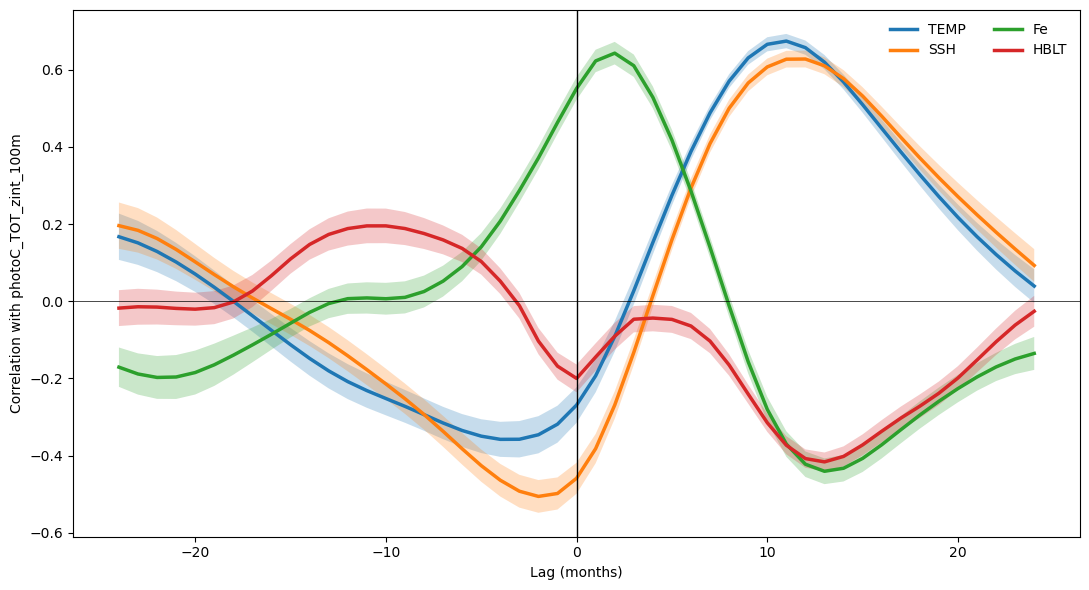

In [22]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.signal import detrend

# ==================================================
# 0. User settings
# ==================================================
data = data_LE  # xarray.Dataset

target_var = "photoC_TOT_zint_100m"
# predictor_vars = ["TEMP", "SSH", "TAUX", "TAUY", "NO3", "Fe", "HBLT"]
predictor_vars = ["TEMP", "SSH", "Fe", "HBLT"]

max_lag = 24  # months
lags = np.arange(-max_lag, max_lag + 1)

# ==================================================
# 1. Preprocessing function
#    - remove monthly climatology
#    - remove linear trend
#    - apply 3-month running mean
# ==================================================
def preprocess_ts(da):
    # remove monthly climatology
    clim = da.groupby("time.month").mean("time")
    da_anom = da.groupby("time.month") - clim

    # remove linear trend
    da_detrended = xr.apply_ufunc(
        detrend,
        da_anom,
        input_core_dims=[["time"]],
        output_core_dims=[["time"]],
        vectorize=False,
    )

    # 3-month running mean (centered)
    da_smooth = da_detrended.rolling(time=3, center=True).mean()

    return da_smooth

# ==================================================
# 2. Lead–lag correlation function
# ==================================================
def lead_lag_corr(x, y, lags):
    """
    Positive lag: x leads y
    Negative lag: x lags y
    """
    r = np.full(len(lags), np.nan)

    for i, lag in enumerate(lags):
        if lag > 0:
            r[i] = np.corrcoef(x[:-lag], y[lag:])[0, 1]
        elif lag < 0:
            r[i] = np.corrcoef(x[-lag:], y[:lag])[0, 1]
        else:
            r[i] = np.corrcoef(x, y)[0, 1]

    return r

# ==================================================
# 3. Compute ensemble-wise lead–lag correlations
# ==================================================
corrs = {}

for v in predictor_vars:
    corr_ens = []

    for m in data.ens_LE.values:

        # preprocess predictor and target
        x = preprocess_ts(data[v].sel(ens_LE=m))
        y = preprocess_ts(data[target_var].sel(ens_LE=m))

        # convert to numpy and drop NaNs
        x = x.values
        y = y.values
        valid = np.isfinite(x) & np.isfinite(y)

        x = x[valid]
        y = y[valid]

        corr_ens.append(lead_lag_corr(x, y, lags))

    corrs[v] = np.array(corr_ens)  # shape: (ens_LE, lag)

# ==================================================
# 4. Plot: ensemble mean (thick line) + ±1 std spread
# ==================================================
plt.figure(figsize=(11, 6))

for v in predictor_vars:
    corr_ens = corrs[v]

    mean_corr = np.nanmean(corr_ens, axis=0)
    std_corr  = np.nanstd(corr_ens, axis=0)

    plt.plot(
        lags,
        mean_corr,
        linewidth=2.5,
        label=v
    )

    plt.fill_between(
        lags,
        mean_corr - std_corr,
        mean_corr + std_corr,
        alpha=0.25
    )

plt.axvline(0, color="k", linewidth=1)
plt.axhline(0, color="k", linewidth=0.5)

plt.xlabel("Lag (months)")
plt.ylabel(f"Correlation with {target_var}")
plt.legend(ncol=2, frameon=False)
plt.tight_layout()
plt.show()


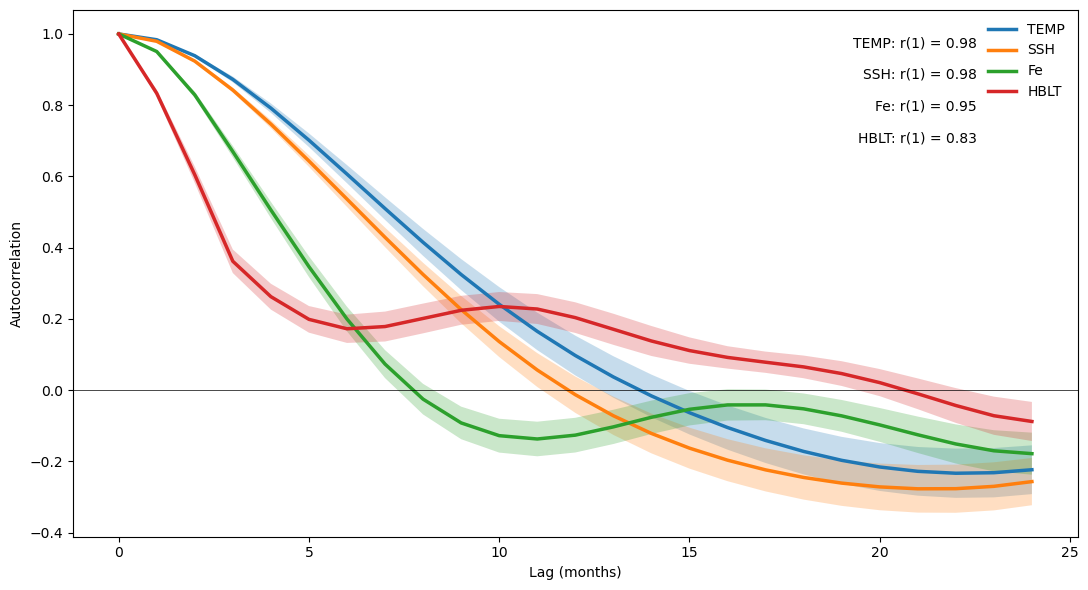

In [26]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.signal import detrend

# ==================================================
# 0. Settings
# ==================================================
data = data_LE  # xarray.Dataset with dims (ens_LE, time)

variables = [
    "TEMP",
    "SSH",
    "Fe",
    "HBLT",
]

max_lag = 24  # months
lags = np.arange(-max_lag, max_lag + 1)
lags_pos = lags[lags >= 0]  # only positive lags

# ==================================================
# 1. Preprocessing function
# ==================================================
def preprocess_ts(da):
    clim = da.groupby("time.month").mean("time")
    da_anom = da.groupby("time.month") - clim

    da_detrended = xr.apply_ufunc(
        detrend,
        da_anom,
        input_core_dims=[["time"]],
        output_core_dims=[["time"]],
        vectorize=False,
    )

    da_smooth = da_detrended.rolling(time=3, center=True).mean()
    return da_smooth

# ==================================================
# 2. Lead–lag autocorrelation function
# ==================================================
def lead_lag_autocorr(x, lags):
    r = np.full(len(lags), np.nan)

    for i, lag in enumerate(lags):
        if lag > 0:
            r[i] = np.corrcoef(x[:-lag], x[lag:])[0, 1]
        elif lag < 0:
            r[i] = np.corrcoef(x[-lag:], x[:lag])[0, 1]
        else:
            r[i] = 1.0

    return r

# ==================================================
# 3. Compute ensemble-wise autocorrelations
# ==================================================
acfs = {}

for v in variables:
    acf_ens = []

    for m in data.ens_LE.values:
        x = preprocess_ts(data[v].sel(ens_LE=m)).values
        valid = np.isfinite(x)
        x = x[valid]

        acf_ens.append(lead_lag_autocorr(x, lags))

    acfs[v] = np.array(acf_ens)  # (ens_LE, lag)

# ==================================================
# 4. Plot: positive lags only + lead-1 annotation
# ==================================================
plt.figure(figsize=(11, 6))

y_text_start = 0.95
dy = 0.06  # vertical spacing for text

for i, v in enumerate(variables):
    acf_ens = acfs[v]

    mean_acf = np.nanmean(acf_ens, axis=0)
    std_acf  = np.nanstd(acf_ens, axis=0)

    mean_pos = mean_acf[lags >= 0]
    std_pos  = std_acf[lags >= 0]

    plt.plot(
        lags_pos,
        mean_pos,
        linewidth=2.5,
        label=v
    )

    plt.fill_between(
        lags_pos,
        mean_pos - std_pos,
        mean_pos + std_pos,
        alpha=0.25
    )

    # ---- lead-1 autocorrelation annotation ----
    lead1_val = mean_acf[lags == 1][0]
    plt.text(
        0.90,
        y_text_start - i * dy,
        f"{v}: r(1) = {lead1_val:.2f}",
        transform=plt.gca().transAxes,
        ha="right",
        va="top",
        fontsize=10
    )

plt.axhline(0, color="k", linewidth=0.5)

plt.xlabel("Lag (months)")
plt.ylabel("Autocorrelation")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()


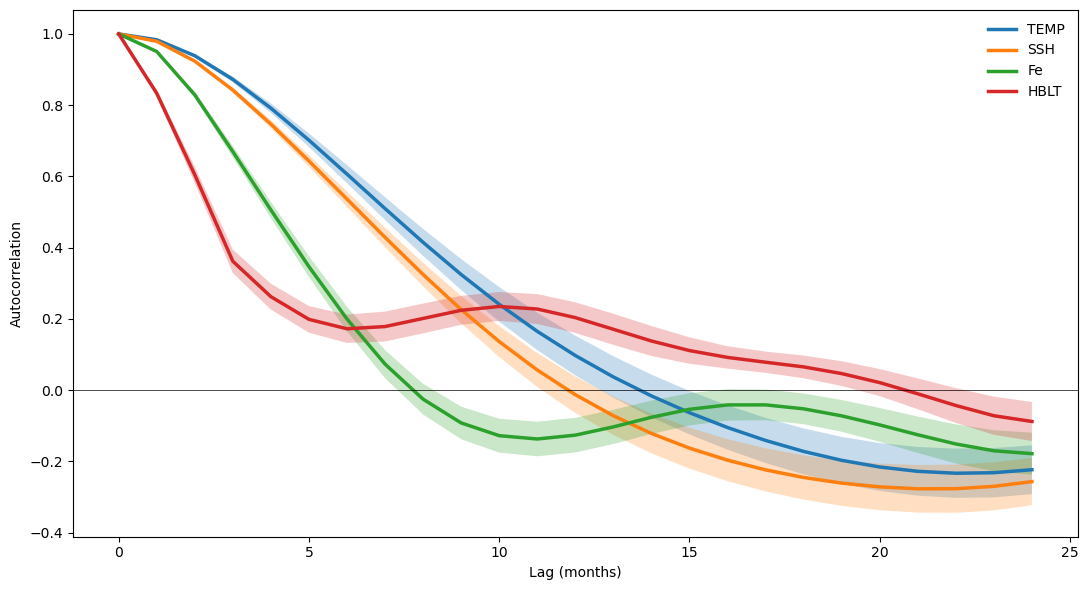

In [28]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.signal import detrend

def efolding_timescale(lags, acf):
    """
    Compute e-folding timescale from autocorrelation.
    Uses the first crossing of exp(-1).
    """
    target = np.exp(-1)

    # use only positive lags, excluding lag=0
    lags_pos = lags[lags > 0]
    acf_pos  = acf[lags > 0]

    # must be monotonically decreasing in practice,
    # but we search robustly
    for i in range(len(acf_pos) - 1):
        if acf_pos[i] >= target and acf_pos[i + 1] < target:
            # linear interpolation
            x0, x1 = lags_pos[i], lags_pos[i + 1]
            y0, y1 = acf_pos[i], acf_pos[i + 1]

            return x0 + (target - y0) * (x1 - x0) / (y1 - y0)

    # if never crosses e^-1
    return np.nan



# ==================================================
# 0. Settings
# ==================================================
data = data_LE

variables = [
    "TEMP",
    "SSH",
    "Fe",
    "HBLT",
]

max_lag = 24
lags = np.arange(-max_lag, max_lag + 1)
lags_pos = lags[lags >= 0]

# ==================================================
# 1. Preprocessing function
# ==================================================
def preprocess_ts(da):
    clim = da.groupby("time.month").mean("time")
    da_anom = da.groupby("time.month") - clim

    da_detrended = xr.apply_ufunc(
        detrend,
        da_anom,
        input_core_dims=[["time"]],
        output_core_dims=[["time"]],
        vectorize=False,
    )

    return da_detrended.rolling(time=3, center=True).mean()

# ==================================================
# 2. Lead–lag autocorrelation
# ==================================================
def lead_lag_autocorr(x, lags):
    r = np.full(len(lags), np.nan)
    for i, lag in enumerate(lags):
        if lag > 0:
            r[i] = np.corrcoef(x[:-lag], x[lag:])[0, 1]
        elif lag < 0:
            r[i] = np.corrcoef(x[-lag:], x[:lag])[0, 1]
        else:
            r[i] = 1.0
    return r

# ==================================================
# 3. e-folding timescale function
# ==================================================
def efolding_timescale(lags, acf):
    target = np.exp(-1)
    lags_p = lags[lags > 0]
    acf_p  = acf[lags > 0]

    for i in range(len(acf_p) - 1):
        if acf_p[i] >= target and acf_p[i + 1] < target:
            x0, x1 = lags_p[i], lags_p[i + 1]
            y0, y1 = acf_p[i], acf_p[i + 1]
            return x0 + (target - y0) * (x1 - x0) / (y1 - y0)

    return np.nan

# ==================================================
# 4. Compute ensemble autocorrelations
# ==================================================
acfs = {}

for v in variables:
    acf_ens = []
    for m in data.ens_LE.values:
        x = preprocess_ts(data[v].sel(ens_LE=m)).values
        x = x[np.isfinite(x)]
        acf_ens.append(lead_lag_autocorr(x, lags))

    acfs[v] = np.array(acf_ens)

# ==================================================
# 5. Plot + e-folding annotation
# ==================================================
plt.figure(figsize=(11, 6))

y_text_start = 0.95
dy = 0.07

for i, v in enumerate(variables):
    acf_ens = acfs[v]
    mean_acf = np.nanmean(acf_ens, axis=0)
    std_acf  = np.nanstd(acf_ens, axis=0)

    mean_pos = mean_acf[lags >= 0]
    std_pos  = std_acf[lags >= 0]

    plt.plot(lags_pos, mean_pos, linewidth=2.5, label=v)
    plt.fill_between(
        lags_pos,
        mean_pos - std_pos,
        mean_pos + std_pos,
        alpha=0.25
    )

    # # ---- e-folding timescale ----
    # tau_e = efolding_timescale(lags, mean_acf)
    # plt.text(
    #     0.90,
    #     y_text_start - i * dy,
    #     f"{v}: τₑ ≈ {tau_e:.1f} months",
    #     transform=plt.gca().transAxes,
    #     ha="right",
    #     va="top",
    #     fontsize=10
    # )
    # Fe: 4.9, SST: 9


plt.axhline(0, color="k", linewidth=0.5)
plt.xlabel("Lag (months)")
plt.ylabel("Autocorrelation")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()
